In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import cv2 as cv
from osgeo import gdal
import netCDF4
import tqdm
from scipy.spatial import ckdtree
plt.ion()
import xml.etree.ElementTree as ET
import scipy.io as io

import cv2 as cv
import matplotlib.pyplot as plt
plt.ion()
import os
import glob
import matplotlib.colors as colors
import numpy as np
import shapefile
import gdal
import gzip
import shutil

from cartopy.io import shapereader
from shapely.ops import cascaded_union

In [2]:
shp = shapereader.Reader('data_val/land/gadm36_CAN_0')

In [ ]:
geoms = shp.geometries()
polygon = cascaded_union(list(geoms))

In [3]:
from shapely.geometry import Point

def inpolygon(polygon, xp, yp):
    return np.array([Point(x, y).intersects(polygon) for x, y in zip(xp, yp)],
                    dtype=np.bool)

In [4]:
def unzip_and_write(filepath):
    if filepath[-2:] == 'gz':
        with gzip.open(filepath, 'rb') as f_in:
            with open(filepath[:-2], 'wb') as f_out:
                shutil.copyfileobj(f_in, f_out)

In [5]:
# under WGS84 Assumption
# "a"
semiMajor = 6.378137000000000e+06
# "b"
semiMinor = 6.356752314245179e+06
# "Rnear"
slant = 8.436862401575363e+05
groundOrigin = 0

In [7]:
land_mask = io.loadmat('landmaskna.mat')
land_mask_val = land_mask['landnafp']
land_mask_flat_lat = land_mask['latvalsna'].flatten()
land_mask_flat_lon = land_mask['lonvalsna'].flatten()
# land_mask_xyz = np.zeros([len(land_mask_flat_lat)*len(land_mask_flat_lon), 3])
# count = 0
# for lon in tqdm.tqdm(land_mask_flat_lon):
#     for lat in land_mask_flat_lat:
#         land_mask_xyz[count] = cart_transform(lat, lon)
#         count = count + 1
        
land_lat_fit = np.poly1d(np.polyfit(land_mask_flat_lat,range(0, len(land_mask_flat_lat)), 1))
land_lon_fit = np.poly1d(np.polyfit(land_mask_flat_lon, range(0, len(land_mask_flat_lon)), 1))

In [8]:
def cart_transform(phi, lam):
    phi_rad = np.pi * phi/180
    lam_rad = np.pi * lam/180
    den = np.sqrt(semiMajor*semiMajor*np.cos(phi_rad)*np.cos(phi_rad) + semiMinor*semiMinor*np.sin(phi_rad)*np.sin(phi_rad))    
    Xuv = (semiMajor*semiMajor * np.cos(phi_rad) * np.cos(lam_rad))/den
    Yuv = (semiMajor*semiMajor * np.cos(phi_rad) * np.sin(lam_rad))/den
    Zuv = (semiMinor*semiMinor*np.sin(phi_rad))/den
    return (Xuv, Yuv, Zuv)

def cart_inv(x,y,z):
    phi_rad = np.arctan(semiMajor*z/(semiMinor*np.sqrt(semiMinor*semiMinor - z*z)))
    lam_rad = np.arctan2(y,x)
    phi = 180*phi_rad/(np.pi)
    lam = 180*lam_rad/(np.pi)
    return phi, lam

def idw(distances):
    if np.count_nonzero(distances) != len(distances):
        weights = np.zeros_like(distances)
        weights[0] = 1
    else:
        inverse_sum = sum([1/d for d in distances])
        weights = (1/distances)/inverse_sum
    return weights

In [9]:
def concentration(lat, lon):
    
    '''
    Given a lat-lon pair interpolate using IDW to find the actual concentration
    '''
    land_pos_y = int(np.round(land_lon_fit(lon)))
    land_pos_x = int(np.round(land_lat_fit(lat)))
    
    land_val = land_mask_val[land_pos_x,land_pos_y]
    
    if not np.isnan(land_val):
        return np.nan
    else:
        return 1
#     dists, idxs = tree.query((lat, lon), samples)
#     concentration_values = np.array([chart_data_flat[i] for i in idxs])
#     nan_vals = np.isnan(concentration_values)
#     if any(nan_vals):
#         return np.nan
#     try:
#         weights = idw(dists)
#     except:
#         weights = 1
#         return chart_data_flat[idxs]
#     return np.sum(np.multiply(concentration_values, weights))

In [10]:
def concentration_Z(x, y):
    
    '''
    Given a lat-lon pair interpolate using IDW to find the actual concentration
    '''
    land_pos_y = int(np.round(land_lon_fit(lon)))
    land_pos_x = int(np.round(land_lat_fit(lat)))
    
    land_val = land_mask_val[land_pos_x,land_pos_y]
    
    if not np.isnan(land_val):
        return np.nan
    else:
        return 1
#     dists, idxs = tree.query((x, y,z), samples)
#     concentration_values = np.array([chart_data_flat[i] for i in idxs])
#     nan_vals = np.isnan(concentration_values)
#     if any(nan_vals):
#         return 255
#     try:
#         weights = idw(dists)
#     except:
#         weights = 1
#         return chart_data_flat[idxs]
#     return np.sum(np.multiply(concentration_values, weights))

In [11]:
# FIX THE GRID FILE, THERE IS SOMETHING WRONG WITH THE LON NUMBERS I BELIEVE
def gen_conc_image(geotiff_path, DOWN_RATE=16):
    dataset = gdal.Open(geotiff_path, gdal.GA_ReadOnly)

    image_shape = [np.round(dataset.RasterYSize/DOWN_RATE).astype(np.int), np.round(dataset.RasterXSize/DOWN_RATE).astype(np.int)]
    print(image_shape)
    
    control_pts = dataset.GetGCPs()
    control_pixel_locations = [(pt.GCPLine/DOWN_RATE, pt.GCPPixel/DOWN_RATE) for pt in control_pts]
    control_tree = ckdtree.cKDTree(control_pixel_locations)
    
    SAMPLES = 6
    pos_values = [cart_transform(pt.GCPY, pt.GCPX) for pt in control_pts]
    concentration_image = np.zeros((image_shape))
#     concentration_z_image = np.zeros((image_shape))
    lat_lon_image = np.zeros((image_shape[0], image_shape[1], 2))
#     lats = []
#     lons = []
    for i in (range(concentration_image.shape[0])):
        for j in range(concentration_image.shape[1]):
            #TODO:  put in max dist for speed
            distances, indices = control_tree.query((i, j), SAMPLES)
            weights = idw(distances)
            X_values = [pos_values[index][0] for index in indices]
            Y_values = [pos_values[index][1] for index in indices]
            Z_values = [pos_values[index][2] for index in indices]
            X = np.sum(np.multiply(X_values, weights))
            Y = np.sum(np.multiply(Y_values, weights))
            Z = np.sum(np.multiply(Z_values, weights))
#             conc_Z = concentration_Z(XYZ_tree, X,Y,Z, chart_data_flat)
            lat, lon = cart_inv(X,Y,Z)
            lat_lon_image[i,j,0] = lat 
            lat_lon_image[i,j,1] = lon
#             lats.append(lat)
#             lons.append(lon)
            conc = concentration(lat, lon)
            concentration_image[i, j] = conc
#             concentration_z_image[i,j] = conc_Z
#     print('Max lat: ', sorted(lats)[-1])
#     print('Min lat: ', sorted(lats)[0])
#     print('Max lon: ', sorted(lons)[-1])
#     print('Min lon: ', sorted(lons)[0])
    
    return concentration_image, lat_lon_image

In [53]:
import tqdm

In [54]:
import os

In [74]:
latlon_folder = r"C:\Users\clvco\Google Drive\3B\URA\final_results\latlon_data_normal\\"
outlat_folder = r"C:\Users\clvco\Google Drive\3B\URA\final_results\latlon_data_revised\\"
results_folder = r"C:\Users\clvco\Google Drive\3B\URA\final_results\prime-large"
mask_folder =  r"C:\Users\clvco\Google Drive\3B\URA\final_results\masks"
for subfolder in glob.glob(os.path.join(latlon_folder, '*')):
    ty = os.path.basename(subfolder)
    if ty == 'gsl':
        continue
    results = glob.glob(os.path.join(results_folder, ty, 'bigger_*.tiff'))
    for result in tqdm.tqdm(results):
        res = cv.imread(result, 0)
        shape = res.shape
        des = os.path.basename(result)[len('bigger_'):-len('.tiff')]
#         try:
#         try:
        hh_folder = glob.glob(os.path.join('c:/Users/clvco/URA_W18/data_val/**/', des), recursive=True)[0]
        files = glob.glob(os.path.join(hh_folder, '*.tif'))
        files = sorted(files, key=os.path.getsize)
        hh_path = files[-1]
#             hh_path = os.path.join(hh_folder, 'imagery_HH.tif')
        assert os.path.exists(hh_path)
        conc, latlon_image = gen_conc_image(hh_path)
#         except:
#             print(des)        
#             pass
#             latpath = os.path.join('C:/Users/clvco/URA_W18/val_lab_viz_big_rev_1/lat_' + des + '.txt')
#             lonpath = os.path.join('C:/Users/clvco/URA_W18/val_lab_viz_big_rev_1/lon_' + des + '.txt')
#             lat = np.loadtxt(latpath)
# #             lat = np.reshape(lat, shape)
#             lon = np.loadtxt(lonpath)
# #             lon = np.reshape(lon, shape)
#             latlon_image = np.stack([lat, lon], axis=-1)
#             latlon_image = np.zeros((shape[0], shape[1], 2))
#             latlon_image[:,:,0] = lat
#             latlon_image[:,:,1] = lon
        latlon_image = cv.resize(latlon_image, shape[::-1])
        conc[conc!= 1] = 255
        cv.imwrite(os.path.join(mask_folder, 'mask_' + des + '.tif'), conc)
#         np.savetxt(os.path.join(outlat_folder, ty, 'lat_' + des + '.txt'), latlon_image[:,:,0])
#         np.savetxt(os.path.join(outlat_folder, ty, 'lon_' + des + '.txt'), latlon_image[:,:,1])
        
        

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

[632, 661]


 10%|████████▎                                                                          | 1/10 [00:59<08:51, 59.06s/it]

[162, 658]


 20%|████████████████▌                                                                  | 2/10 [01:14<04:58, 37.34s/it]

[622, 658]


 30%|████████████████████████▉                                                          | 3/10 [02:14<05:13, 44.84s/it]

[628, 658]


 40%|█████████████████████████████████▏                                                 | 4/10 [03:15<04:53, 48.91s/it]

[632, 661]


 50%|█████████████████████████████████████████▌                                         | 5/10 [04:14<04:14, 50.98s/it]

[628, 658]


 60%|█████████████████████████████████████████████████▊                                 | 6/10 [05:12<03:28, 52.05s/it]

[505, 660]


 70%|██████████████████████████████████████████████████████████                         | 7/10 [05:59<02:34, 51.34s/it]

[628, 662]


 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [07:06<01:46, 53.32s/it]

[632, 658]


 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [08:03<00:53, 53.76s/it]

[623, 661]


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [09:00<00:00, 54.05s/it]


In [66]:
des[:-12]

'RS2_OK45827_PK443017_DK394473_SCWA_20131112_1058'

In [71]:
glob.glob(os.path.join('C:/Users/clvco/URA_W18/data_val/**/', '*' + des), recursive=True)

['C:/Users/clvco/URA_W18/data_val\\lab_sea\\2013_data\\RS2_OK45827_PK443017_DK394473_SCWA_20131112_105831_HH_HV_SGF']

In [12]:
p = 'c:/Users/clvco/URA_W18/data_val//images_gsl2014//RS2_OK47570_PK459345_DK409231_SCWA_20140117_103914_HH_HV_SGF/imagery_HH.tif'

In [39]:
conc[conc!=1] = 255

In [40]:
cv.imwrite('C:/users/clvco/Desktop/test/CONC.png', conc)

True

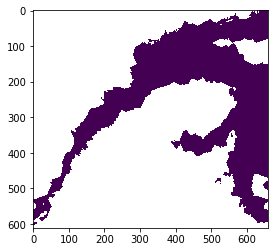

In [34]:
plt.imshow(conc)

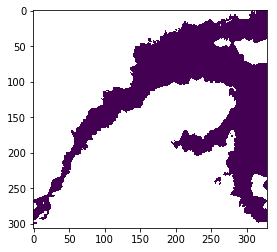

In [22]:
plt.imshow(conc)

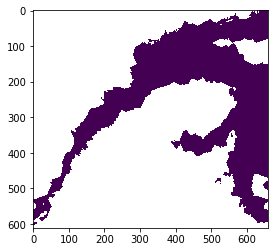

In [25]:
plt.imshow(conc)

In [13]:
hv = cv.imread(p)

In [55]:
mp = r"C:\Users\clvco\Google Drive\3B\URA\final_results\prime-large\gsl\new_mask_RS2_OK47570_PK459345_DK409231_SCWA_20140117_103914_HH_HV_SGF.tiff"

In [56]:
mask = cv.imread(mp, 0)

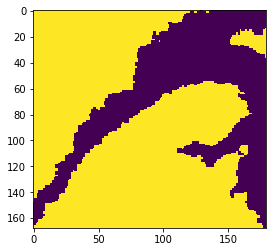

In [57]:
plt.imshow(mask)

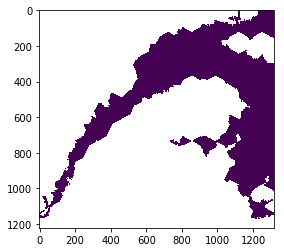

In [59]:
plt.imshow(conc)

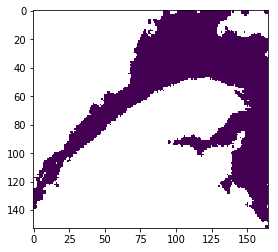

In [79]:
plt.imshow(conc)

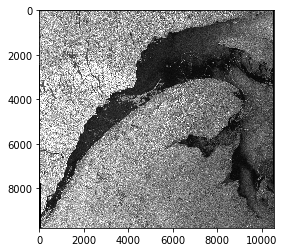

In [14]:
plt.imshow(hv)

In [26]:
hvc = cv.resize(hv, conc.shape[0:2][::-1])

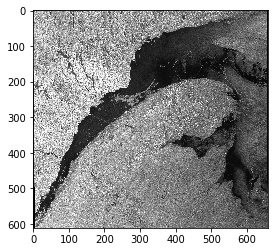

In [27]:
plt.imshow(hvc)

In [28]:
hvc = hvc[:,:,0]

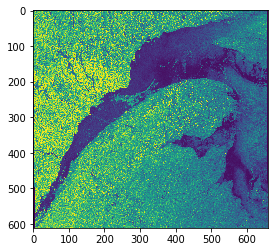

In [29]:
plt.imshow(hvc)

In [30]:
hvcc = hvc.copy().astype(np.float32)

In [31]:
hvcc[conc!=1] = 0

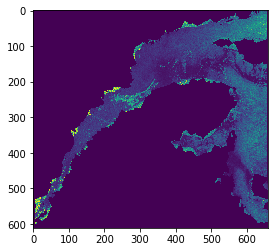

In [32]:
plt.imshow(hvcc)

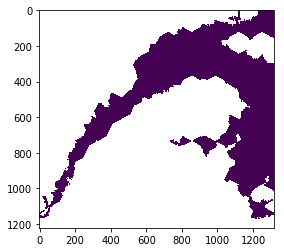

In [42]:
plt.imshow(conc)

In [31]:
subfolder

'C:\\Users\\clvco\\Google Drive\\3B\\URA\\final_results\\latlon_data_normal\\lab'

In [27]:
hh_folder

'c:/Users/clvco/URA_W18/data_val\\images_gsl2014\\RS2_OK47585_PK460583_DK410313_SCWA_20140124_215646_HH_HV_SGF'

In [24]:
results

['C:\\Users\\clvco\\Google Drive\\3B\\URA\\final_results\\prime-large\\gsl\\bigger_RS2_OK47583_PK460563_DK410297_SCWA_20140123_222627_HH_HV_SGF.tiff',
 'C:\\Users\\clvco\\Google Drive\\3B\\URA\\final_results\\prime-large\\gsl\\bigger_RS2_OK47600_PK463349_DK412398_SCWA_20140131_103053_HH_HV_SGF.tiff',
 'C:\\Users\\clvco\\Google Drive\\3B\\URA\\final_results\\prime-large\\gsl\\bigger_RS2_OK47581_PK464167_DK410878_SCWA_20140122_095247_HH_HV_SGF.tiff',
 'C:\\Users\\clvco\\Google Drive\\3B\\URA\\final_results\\prime-large\\gsl\\bigger_RS2_OK47570_PK459345_DK409231_SCWA_20140117_103914_HH_HV_SGF.tiff',
 'C:\\Users\\clvco\\Google Drive\\3B\\URA\\final_results\\prime-large\\gsl\\bigger_RS2_OK47585_PK460578_DK410308_SCWA_20140124_103501_HH_HV_SGF.tiff',
 'C:\\Users\\clvco\\Google Drive\\3B\\URA\\final_results\\prime-large\\gsl\\bigger_RS2_OK47585_PK460583_DK410313_SCWA_20140124_215646_HH_HV_SGF.tiff',
 'C:\\Users\\clvco\\Google Drive\\3B\\URA\\final_results\\prime-large\\gsl\\bigger_RS2_OK48331

In [21]:
des

'RS2_OK48331_PK464264_DK413375_SCWA_20140209_223030_HH_HV_SGF'

In [67]:
glob.glob(os.path.join('c:/Users/clvco/URA_W18/**/', '*' + des + '*'))

['c:/Users/clvco/URA_W18\\figure_LAB_EXP_1\\RS2_OK45827_PK443017_DK394473_SCWA_20131112_105831_HH_HV_SGF.png',
 'c:/Users/clvco/URA_W18\\figure_LAB_EXP_2\\RS2_OK45827_PK443017_DK394473_SCWA_20131112_105831_HH_HV_SGF.png',
 'c:/Users/clvco/URA_W18\\figure_LAB_EXP_3\\RS2_OK45827_PK443017_DK394473_SCWA_20131112_105831_HH_HV_SGF.png',
 'c:/Users/clvco/URA_W18\\figure_median-filter-5_net_checkpoint_FINAL_LAB\\RS2_OK45827_PK443017_DK394473_SCWA_20131112_105831_HH_HV_SGF.png',
 'c:/Users/clvco/URA_W18\\figure_median-filter-5_net_checkpoint_FINAL_LARGE_LAB\\RS2_OK45827_PK443017_DK394473_SCWA_20131112_105831_HH_HV_SGF.png',
 'c:/Users/clvco/URA_W18\\figure_median-filter-5_net_checkpoint_FINAL_LARGE_LAB_BIGGER\\RS2_OK45827_PK443017_DK394473_SCWA_20131112_105831_HH_HV_SGF.png',
 'c:/Users/clvco/URA_W18\\figure_median-filter-5_normal_checkpoint_LARGE_LAB\\RS2_OK45827_PK443017_DK394473_SCWA_20131112_105831_HH_HV_SGF.png',
 'c:/Users/clvco/URA_W18\\figure_median-filter-5_normal_save_LARGE3_LAB\\RS2_

In [70]:
lat.shape

(155, 164)

In [41]:
reimage = cv.resize(lat_image, shape[::-1])

In [44]:
reimage.shape

(168, 180, 2)

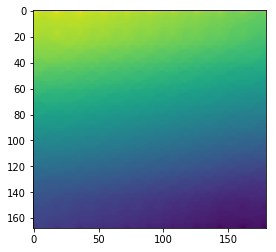

In [47]:
plt.imshow(reimage[:,:,0])

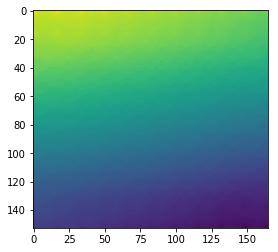

In [48]:
plt.imshow(lat_image[:,:,0])

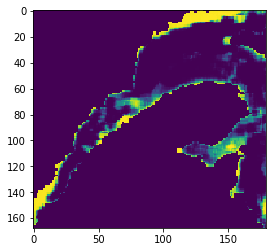

In [46]:
plt.imshow(res)

In [54]:
new_masks = []
gsl_paths = ['20140117_1039', '20140131_215']
gpl = []
for gp in gsl_paths:
    gpl += glob.glob(os.path.join('data_val', 'images_gsl2014/**' + gp + '*'))
for gsl_path in gpl:
    tf =os.path.join(gsl_path, 'imagery_HH.tif')
    conc, ll = gen_conc_image(tf)
    conc[conc!=1]=255
    cv.imwrite('masks/new_mask_' + os.path.basename(gsl_path)  + '.tiff', conc)
    new_masks.append(conc)
#     break

[153, 165]
[159, 165]


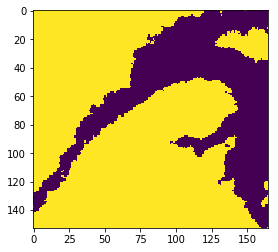

In [57]:
plt.imshow(new_masks[0], vmax=255)

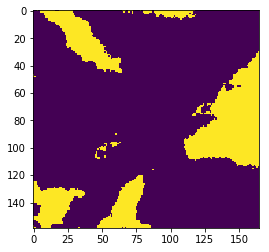

In [55]:
plt.imshow(conc)

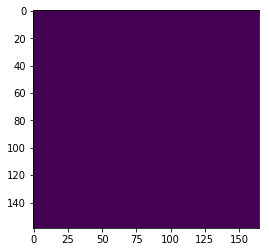

In [50]:
plt.imshow(conc==f)

In [9]:
target_dir = 'results_train_big/'
files =  os.listdir(target_dir)

In [12]:
out_name = 'train_big_dilate'
os.makedirs(out_name, exist_ok=True)

In [108]:
for k,result in enumerate(glob.glob(target_dir + 'bigger*.tiff')):
#     try:
    norm = colors.Normalize(0, 200)
    res_image = cv.imread(result, 0)
#     break
    it = 3
#     res_image = cv.morphologyEx(res_image, cv.MORPH_CLOSE, (5,5), iterations=it)
    res_image = cv.GaussianBlur(res_image, (3,3), 0)
    folder_name = os.path.splitext(os.path.basename(result))[0][len('bigger_'):]
    if (folder_name not in good_folders):
        break
    #     folder_name = os.path.basename(result)[:-5]
        print(folder_name)
        f = 'training_data/' + folder_name
        geotiffs = glob.glob(os.path.join(f, 'RS2*.tif'))
        geotiff = sorted(geotiffs, key=os.path.getsize)[-1]
#         if (len(geotiffs) == 0):

    #         gzfiles = glob.glob(os.path.join(f, '*SGF_HH.tif.gz'))
    #         unzip_and_write(gzfiles[0])
    #         print('unzipping: ', gzfiles[0])
#             geotiff = glob.glob(os.path.join(f, 'RS2_*.tif'))[0]
#         else:
#             geotiff = glob.glob(os.path.join(f, 'RS2*_.tif'))[0]

    #     conc_image = cv.imread(os.path.join('training_data', folder_name, 'conc.tiff'), 0).astype(np.float32)
        hh_path = os.path.join(f, 'imagery_HH.tif')
        mask, latlon = gen_conc_image(geotiff)
        np.savetxt(out_name + '/lat_' + folder_name + '.txt', latlon[:,:,0])
        np.savetxt(out_name + '/lon_' + folder_name + '.txt', latlon[:,:,1])

    #     break
        mask = cv.imread(os.path.dirname(result) + '/new_mask' + os.path.basename(result)[len('bigger'):], cv.IMREAD_GRAYSCALE)
        hh_image = cv.imread(hh_path)
        mask = mask.astype(np.float)
        mask[mask == 255] = np.nan
        mask[mask == 0] = 1
        new_mask = cv.resize(mask, res_image.shape[::-1])
        res_image = np.multiply(res_image, new_mask)
        a = cv.dilate(np.isnan(res_image).astype(np.uint8), (3,3), iterations=5)
        a = a.astype(np.float)
        cv.imwrite(os.path.join(target_dir, folder_name + '_mask.png'), a*255)
        a[a==1] = np.nan
        a[a==0] = 1
        res_image = np.multiply(a, res_image)
    #     plt.imshow(np.multiply(a, res_image))
    #     res_image = sig.convolve2d()
    #     conc_image[conc_image>100] = np.nan
        f, axarr = plt.subplots(1, 2, figsize=(15, 8))
    #     im1 = axarr[0].imshow(conc_image, norm=norm)
    #     axarr[0].set_title('Microwave - ' +folder_name)
        im2 = axarr[0].imshow(res_image, norm=norm)
        axarr[0].set_title('DenseNet')

        im3 = axarr[1].imshow(hh_image, norm=norm)
        axarr[1].set_title('HH SAR')
    #     break
    #     break
        f.savefig(out_name + '/' + folder_name + '.png', bbox_inches='tight', pad_inches=0)
    #     break
#         good_folders.append( folder_name)
        break
#     except:
#         print('bad',folder_name)

In [106]:
del good_folders[-1]

In [14]:
mask = mask.astype(np.float)
mask[mask == 255] = np.nan
mask[mask == 0] = 255

In [109]:
rcp = res_image.copy()

In [164]:
down_factor = 16

In [156]:
res_image = res_image.astype(np.float)

In [165]:
rs = cv.resize(rcp, (rcp.shape[0]//down_factor, rcp.shape[1]//down_factor)).astype(np.float)

In [166]:
rd = cv.dilate(rs, (3,3))

In [167]:
res = cv.resize(rd, rcp.shape[::-1])

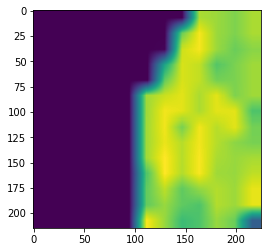

In [168]:
plt.imshow(res)

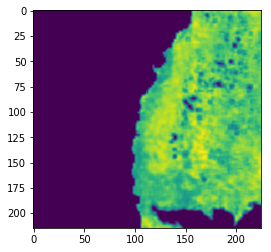

In [169]:
plt.imshow(res_image)

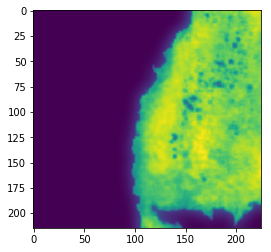

In [180]:
plt.imshow(np.add(res_image,rb))

In [182]:
rr = np.round(rcp.astype(np.float32)/200)

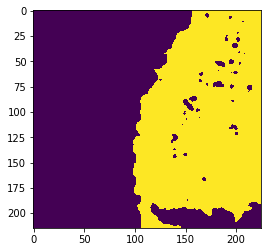

In [193]:
plt.imshow(rr)

In [195]:
rr.dtype

dtype('float32')

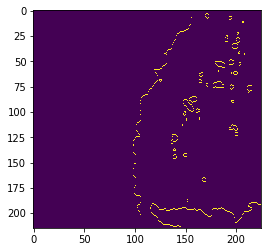

In [205]:
plt.imshow(np.bitwise_xor(rr.astype(np.uint8),cv.morphologyEx(rr, cv.MORPH_OPEN, (3,3), iterations=1).astype(np.uint8)))

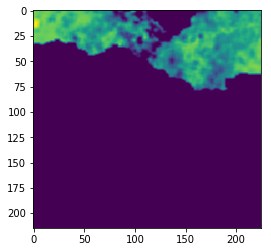

In [67]:
plt.imshow(rb)

In [93]:
rn = rb.astype(np.float32)/200

In [82]:
rn

array([[ 0.97500002,  0.98000002,  0.98000002, ...,  0.75999999,
         0.75999999,  0.76999998],
       [ 0.98500001,  0.98500001,  0.98500001, ...,  0.77999997,
         0.78500003,  0.79500002],
       [ 0.99000001,  0.99000001,  0.99000001, ...,  0.80000001,
         0.80000001,  0.81      ],
       ..., 
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]], dtype=float32)

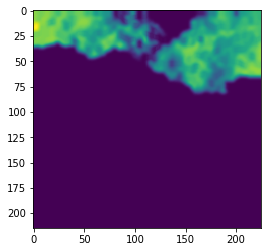

In [94]:
plt.imshow(cv.morphologyEx(rn, cv.MORPH_CLOSE, (9,9), iterations=3))

In [ ]:
cv.GaussianBlur()

In [16]:
os.path.dirname(result) + '/new_mask' + os.path.basename(result)[len('bigger'):]

'results_train_big/new_mask_20110903D.tiff'

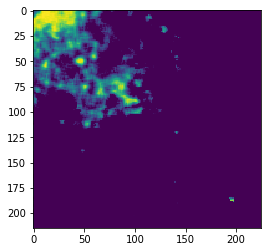

In [17]:
a = cv.dilate(np.isnan(res_image).astype(np.uint8), (3,3), iterations=5)
a = a.astype(np.float)
a[a==1] = np.nan
a[a==0] = 1
plt.imshow(np.multiply(a, res_image))

TypeError: Image data cannot be converted to float

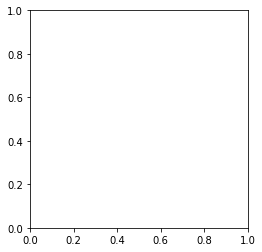

In [18]:
plt.imshow(cv.imread(r"C:\Users\clvco\URA_W18\results_glsl\RS2_OK47581_PK464167_DK410878_SCWA_20140122_095247_HH_HV_SGF_mask.tif"))

In [ ]:
plt.imshow(a)

In [ ]:
cv.imwrite('test.tif', a)

In [ ]:
plt.imshow(np.multiply(a, res_image))

In [ ]:
plt.imshow(a)

In [ ]:
gzfiles

### Interpolate land features

In [3]:
import os
import numpy 
import cv2 as cv
import glob

In [17]:
latlon_folder = r"C:\Users\clvco\Google Drive\3B\URA\final_results\latlon_data_normal\\"
outlat_folder = r"C:\Users\clvco\Google Drive\3B\URA\final_results\latlon_data_large\\"
results_folder = r"C:\Users\clvco\Google Drive\3B\URA\final_results\prime-large"
for subfolder in glob.glob(os.path.join(latlon_folder, '*')):
    ty = os.path.basename(subfolder)
    results = glob.glob(os.path.join(results_folder, ty, 'bigger_*.tiff'))
    for result in results:
        res = cv.imread(result, 0)
        shape = res.shape
        des = os.path.basename(result)[len('bigger_'):-len('.tiff')]
        lat = os.path.join(latlon_folder, ty, 'lat_' + des + '.txt')
        print(lat)
        asdfadsf

C:\Users\clvco\Google Drive\3B\URA\final_results\latlon_data_normal\\gsl\lat_RS2_OK47570_PK459345_DK409231_SCWA_20140117_103914_HH_HV_SGF.txt


NameError: name 'asdfadsf' is not defined

In [18]:
os.path.exists(lat)

False

In [16]:
os.path.join(latlon_folder, ty, 'lat_' + des + '*')

'C:\\Users\\clvco\\Google Drive\\3B\\URA\\final_results\\latlon_data_normal\\\\gsl\\lat_RS2_OK47570_PK459345_DK409231_SCWA_20140117_103914_HH_HV_SGF*'

In [5]:
subfolders


['C:\\Users\\clvco\\Google Drive\\3B\\URA\\final_results\\latlon_data_normal\\gsl',
 'C:\\Users\\clvco\\Google Drive\\3B\\URA\\final_results\\latlon_data_normal\\lab']